In [1]:
import flexynesis 
import torch, os
torch.set_num_threads(12)

In [2]:
if not os.path.exists("dataset1"):
    !wget -O ccle_gdsc.tgz "https://bimsbstatic.mdc-berlin.de/akalin/buyar/flexynesis-benchmark-datasets/dataset1.tgz" && tar -xzvf ccle_gdsc.tgz

In [37]:
data_importer = flexynesis.DataImporter(path ='./dataset1/', 
                                       data_types = ['gex', 'cnv'], 
                                        concatenate=False, min_features=100, top_percentile=25)

In [38]:
train_dataset, test_dataset = data_importer.import_data()


[INFO] ================= Importing Data =================
[INFO] Validating data folders...

[INFO] ----------------- Reading Data -----------------
[INFO] Importing ./dataset1/train/cnv.csv...
[INFO] Importing ./dataset1/train/gex.csv...
[INFO] Importing ./dataset1/train/clin.csv...

[INFO] ----------------- Reading Data -----------------
[INFO] Importing ./dataset1/test/cnv.csv...
[INFO] Importing ./dataset1/test/gex.csv...
[INFO] Importing ./dataset1/test/clin.csv...

[INFO] ---------- Processing Data (train) ----------

[INFO] --------------- Cleaning Up Data ---------------
Number of NA values:  0
[INFO] DataFrame gex - Removed 0 features.
Number of NA values:  0
[INFO] DataFrame cnv - Removed 0 features.
DataFrame gex - Removed 0 samples (0.00%).
DataFrame cnv - Removed 0 samples (0.00%).
Implementing feature selection using laplacian score for layer: gex with  3422 features


Calculating Laplacian scores: 100%|██████████| 3422/3422 [00:00<00:00, 15899.87it/s]
Removing redundant features among top scoring ones: 100%|██████████| 1197/1197 [00:00<00:00, 1906.85it/s]


Implementing feature selection using laplacian score for layer: cnv with  157 features


Calculating Laplacian scores: 100%|██████████| 157/157 [00:00<00:00, 16929.47it/s]
Removing redundant features among top scoring ones: 100%|██████████| 115/115 [00:00<00:00, 19636.25it/s]



[INFO] ---------- Processing Data (test) ----------

[INFO] --------------- Cleaning Up Data ---------------
Number of NA values:  0
[INFO] DataFrame gex - Removed 0 features.
Number of NA values:  0
[INFO] DataFrame cnv - Removed 0 features.
DataFrame gex - Removed 0 samples (0.00%).
DataFrame cnv - Removed 0 samples (0.00%).

[INFO] ------------ Harmonizing Data Sets ------------

[INFO] --------------- Normalizing Data ---------------

[INFO] --------------- Normalizing Data ---------------
[INFO] Data import successful.


In [39]:
tuner = flexynesis.HyperparameterTuning(train_dataset, 
                                        model_class = flexynesis.DirectPred, 
                                        target_variables = "Erlotinib",
                                        config_name = "DirectPred", 
                                        config_path = './conf.yaml',
                                        n_iter=20, plot_losses=True, early_stop_patience=10)

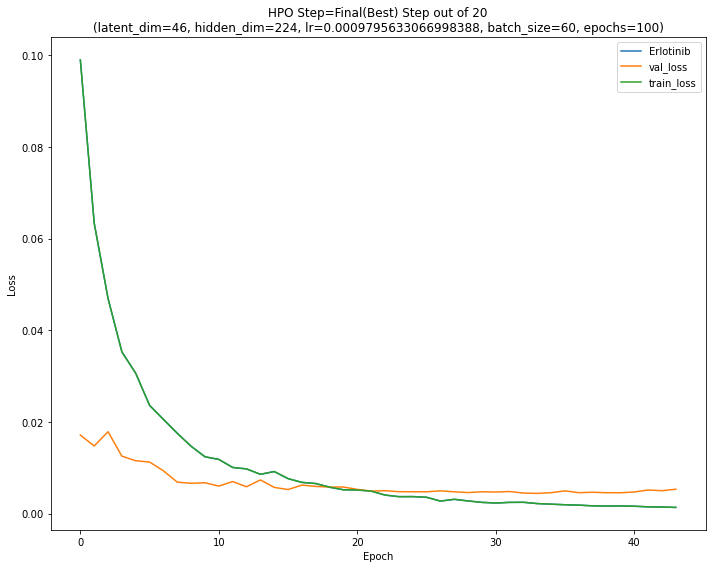

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.004. Signaling Trainer to stop.


{'latent_dim': 46,
 'hidden_dim': 224,
 'lr': 0.0009795633066998388,
 'batch_size': 60,
 'epochs': 100}

In [40]:
model, best_params = tuner.perform_tuning()
best_params

In [41]:
y_pred_dict = model.predict(test_dataset)

In [44]:
metrics_df = flexynesis.evaluate_wrapper(y_pred_dict, test_dataset)
metrics_df

,var,variable_type,metric,value
0,Erlotinib,numerical,mse,0.004879
1,Erlotinib,numerical,r2,0.217277
2,Erlotinib,numerical,pearson_corr,0.477792


In [ ]:
y_pred_dict.

In [54]:
flexynesis.plot_scatter(test_dataset.ann['Erlotinib'], y_pred_dict['Erlotinib'])

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [45]:
for var in model.target_variables:
    model.compute_feature_importance(var, steps = 50)

In [46]:
top_features = flexynesis.get_important_features(model, "Erlotinib", top=10)

In [47]:
top_features

,target_variable,target_class,layer,name,importance
0,Erlotinib,0,cnv,EGFR,0.002722
1,Erlotinib,0,cnv,ANK1,0.002516
2,Erlotinib,0,cnv,ANK2,0.002497
3,Erlotinib,0,cnv,FLRT3,0.002425
4,Erlotinib,0,cnv,MEF2C,0.002234
5,Erlotinib,0,cnv,CCL21,0.002216
6,Erlotinib,0,cnv,HBQ1,0.002012
7,Erlotinib,0,cnv,NDP,0.001925
8,Erlotinib,0,cnv,PARP11,0.001918
9,Erlotinib,0,cnv,ARID1A,0.001780


In [49]:
df = test_dataset.get_feature_subset(top_features)
df

,cnv_EGFR,cnv_ANK1,cnv_ANK2,cnv_FLRT3,cnv_MEF2C,cnv_CCL21,cnv_HBQ1,cnv_NDP,cnv_PARP11,cnv_ARID1A
target_dataset:DU4475,1.370797,1.130338,1.800939,0.917734,-2.545938,1.117338,1.336606,1.570869,0.930521,1.551428
target_dataset:Hs 698.T,-0.846271,-0.511439,-0.356987,-0.702023,-0.583435,-0.507990,-0.585408,-0.339110,-0.644147,-0.480054
target_dataset:SK-N-MC,-1.201197,1.304022,-0.577348,-1.033894,-0.886938,-0.623495,-0.641721,0.084442,-0.735404,-0.332914
target_dataset:P31/FUJ,-0.091042,-0.538863,-0.389235,-0.903785,-0.485310,-0.524490,-0.737210,-0.745347,-0.615023,-0.472934
target_dataset:BT-483,-1.385952,-2.116651,-1.195433,0.595291,1.007105,3.677023,0.332752,-7.028034,-1.203339,1.202564
...,...,...,...,...,...,...,...,...,...,...
target_dataset:HCC78,-0.272556,1.234549,-0.537038,0.810253,0.623733,0.552186,-0.105516,1.612159,-0.838311,-0.200013
target_dataset:OVK18,-1.032648,-0.718032,-0.631094,-0.856644,-0.836735,-0.751376,-0.869425,0.424082,-0.838311,-0.696017
target_dataset:J82,-0.865719,0.417317,-2.109125,-0.315468,0.411508,0.492371,0.068322,-0.650780,-0.102430,-0.302062
target_dataset:Hs 940.T,-0.606413,0.305793,0.696446,-0.006225,0.429764,-0.254290,0.411101,0.297550,-1.071307,-0.185774


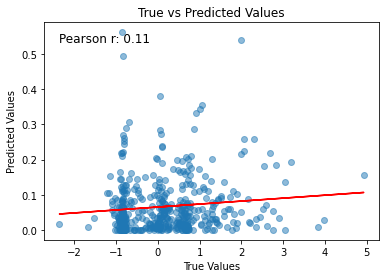

In [51]:
f = 'cnv_EGFR'
flexynesis.plot_scatter(df[f], test_dataset.ann['Erlotinib'])

In [52]:
response_category = flexynesis.split_by_median(test_dataset.ann['Erlotinib'])

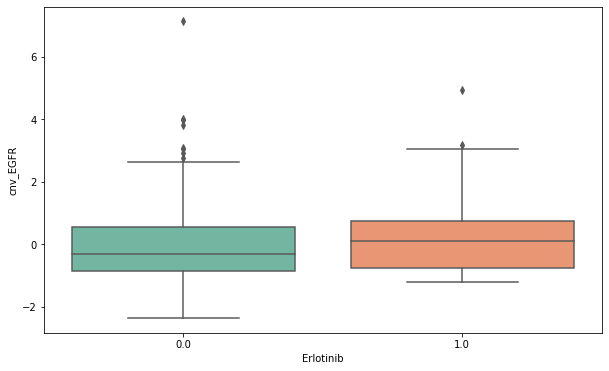

In [53]:
flexynesis.plot_boxplot(response_category, df[f], 'Erlotinib', f)